<a href="https://colab.research.google.com/github/rubenmejiac/CS101/blob/main/Mi_VQGAN%2BCLIP_(z%2Bquantize_method_con_augmentations%2C_interface_amigable).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

# Genera imágenes desde frases de texto con VQGAN y CLIP (método z+quantize con augmentations).

Notebook hecho por Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings), y modificado por Ruben Mejia Corleto (https://github.com/rubenmejiac). El método BigGAN+CLIP original fue hecho por https://twitter.com/advadnoun. Traducido y agregadas explicaciones, y modificaciones por Eleiber#8347, y la interfaz amigable fue hecha gracias a Abulafia#3734.

Para un tutorial detallado de cómo usarlo, recomiendo [visitar este artículo](https://tuscriaturas.miraheze.org/wiki/Ayuda:Crear_imágenes_con_VQGAN+CLIP), hecho por Jakeukalane#2767 y Avengium (Ángel)#3715


In [1]:
!nvidia-smi

Tue Sep 21 13:36:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# @title Instalación de librerías
# @markdown Esta celda se tarda un poco porque tiene que descargar varias librerías
 
print("Descargando CLIP...")
!git clone https://github.com/openai/CLIP                 &> /dev/null
 
print("Instalando bibliotecas de Python para AI...")
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install ftfy regex tqdm omegaconf pytorch-lightning  &> /dev/null
!pip install kornia                                       &> /dev/null
!pip install einops                                       &> /dev/null
!pip install wget                                         &> /dev/null
 
print("Instalando librerías para manejo de metadata...")
!pip install stegano                                      &> /dev/null
!apt install exempi                                       &> /dev/null
!pip install python-xmp-toolkit                           &> /dev/null
!pip install imgtag                                       &> /dev/null
!pip install pillow==7.1.2                                &> /dev/null
 
print("Instalando librerías de Python para la creación de videos...")
!pip install imageio-ffmpeg                               &> /dev/null
!mkdir steps
print("Instalación finalizada.")

Descargando CLIP...
Instalando bibliotecas de Python para AI...
Instalando librerías para manejo de metadata...
Instalando librerías de Python para la creación de videos...
mkdir: cannot create directory ‘steps’: File exists
Instalación finalizada.


In [3]:
#@title Selección de modelos a descargar
#@markdown Por defecto, el notebook descarga el modelo 16384 de ImageNet. Existen otros que no se descargan por defecto, ya que sería en vano si no los vas a usar, así que si quieres usarlos, simplemente selecciona los modelos a descargar.

imagenet_1024 = False #@param {type:"boolean"}
imagenet_16384 = True #@param {type:"boolean"}
gumbel_8192 = True #@param {type:"boolean"}
coco = False #@param {type:"boolean"}
faceshq = False #@param {type:"boolean"}
wikiart_1024 = False #@param {type:"boolean"}
wikiart_16384 = True #@param {type:"boolean"}
sflckr = False #@param {type:"boolean"}
ade20k = False #@param {type:"boolean"}
ffhq = False #@param {type:"boolean"}
celebahq = False #@param {type:"boolean"}

if imagenet_1024:
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024
if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
if gumbel_8192:
  !curl -L -o gumbel_8192.yaml -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #Gumbel 8192
  !curl -L -o gumbel_8192.ckpt -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #Gumbel 8192
if coco:
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if faceshq:
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if wikiart_1024: 
  !curl -L -o wikiart_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart.yaml' #WikiArt 1024
  !curl -L -o wikiart_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart.ckpt' #WikiArt 1024
if wikiart_16384: 
  !curl -L -o wikiart_16384.yaml -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' #WikiArt 16384
  !curl -L -o wikiart_16384.ckpt -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' #WikiArt 16384
if sflckr:
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR
if ade20k:
  !curl -L -o ade20k.yaml -C - 'https://static.miraheze.org/intercriaturaswiki/b/bf/Ade20k.txt' #ADE20K
  !curl -L -o ade20k.ckpt -C - 'https://app.koofr.net/content/links/0f65c2cd-7102-4550-a2bd-07fd383aac9e/files/get/last.ckpt?path=%2F2020-11-20T21-45-44_ade20k_transformer%2Fcheckpoints%2Flast.ckpt' #ADE20K
if ffhq:
  !curl -L -o ffhq.yaml -C - 'https://app.koofr.net/content/links/0fc005bf-3dca-4079-9d40-cdf38d42cd7a/files/get/2021-04-23T18-19-01-project.yaml?path=%2F2021-04-23T18-19-01_ffhq_transformer%2Fconfigs%2F2021-04-23T18-19-01-project.yaml&force' #FFHQ
  !curl -L -o ffhq.ckpt -C - 'https://app.koofr.net/content/links/0fc005bf-3dca-4079-9d40-cdf38d42cd7a/files/get/last.ckpt?path=%2F2021-04-23T18-19-01_ffhq_transformer%2Fcheckpoints%2Flast.ckpt&force' #FFHQ
if celebahq:
  !curl -L -o celebahq.yaml -C - 'https://app.koofr.net/content/links/6dddf083-40c8-470a-9360-a9dab2a94e96/files/get/2021-04-23T18-11-19-project.yaml?path=%2F2021-04-23T18-11-19_celebahq_transformer%2Fconfigs%2F2021-04-23T18-11-19-project.yaml&force' #CelebA-HQ
  !curl -L -o celebahq.ckpt -C - 'https://app.koofr.net/content/links/6dddf083-40c8-470a-9360-a9dab2a94e96/files/get/last.ckpt?path=%2F2021-04-23T18-11-19_celebahq_transformer%2Fcheckpoints%2Flast.ckpt&force' #CelebA-HQ

** Resuming transfer from byte position 692
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.7M      0  0:01:03  0:01:03 --:--:-- 14.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   745  100   745    0     0   1217      0 --:--:-- --:--:-- --:--:--  1217
  % Tota

In [4]:
# @title Carga de librerías y definiciones
 
import argparse
import math
from pathlib import Path
import sys
 
sys.path.append('./taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadata 
from libxmp import *         # metadata
import libxmp                # metadata
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        print(config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return


## Herramientas para la ejecución:
Principalmente lo que tendrás que modificar será `textos:`, ahí puedes colocar el o los textos que  quieres generar (separados con `|` ). Es una lista porque puedes poner más de un texto, y así la IA trate de 'mezclar' las imágenes, dándole la misma prioridad a ambos textos.

Para usar una imagen inicial al modelo, solo debes subir un archivo al entorno del Colab (en la sección a la izquierda), y luego modificas `imagen_inicial:` poniendo el nombre exacto del archivo. Ejemplo: `sample.png`

También puedes modificar el modelo cambiando las línea que dice `modelo:`. Actualmente están disponibles 1024, 16384, WikiArt, S-FLCKR y COCO-Stuff. Para activarlos tienes que haberlos descargado primero, y luego puedes simplemente seleccionarlo.

También puedes usar `imagenes_objetivo`, que es básicamente ponerle una o más imágenes que la IA tomará como "meta", cumpliendo la misma función que ponerle un texto. Para poner más de una tienes que usar `|` como separador.

In [13]:
#@title Parámetros
textos = "crocodile | surfing | wave | ocean | blue sky | white clouds | unreal engine style" #@param {type:"string"}
ancho =  672#@param {type:"number"}
alto =  378#@param {type:"number"}
modelo = "vqgan_imagenet_f16_16384" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "wikiart_1024", "wikiart_16384", "coco", "faceshq", "sflckr", "ade20k", "ffhq", "celebahq", "gumbel_8192"]
intervalo_imagenes =  50#@param {type:"number"}
imagen_inicial = "PXL_20210831_205513635.jpg"#@param {type:"string"}
imagenes_objetivo = ""#@param {type:"string"}
seed = -1#@param {type:"number"}
max_iteraciones = 1500#@param {type:"number"}
input_images = ""

nombres_modelos={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 
                 "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR", "ade20k":"ADE20K", "ffhq":"FFHQ", "celebahq":"CelebA-HQ", "gumbel_8192": "Gumbel 8192"}
nombre_modelo = nombres_modelos[modelo]     

if modelo == "gumbel_8192":
    is_gumbel = True
else:
    is_gumbel = False

if seed == -1:
    seed = None
if imagen_inicial == "None":
    imagen_inicial = None
elif imagen_inicial and imagen_inicial.lower().startswith("http"):
    imagen_inicial = download_img(imagen_inicial)


if imagenes_objetivo == "None" or not imagenes_objetivo:
    imagenes_objetivo = []
else:
    imagenes_objetivo = imagenes_objetivo.split("|")
    imagenes_objetivo = [image.strip() for image in imagenes_objetivo]

if imagen_inicial or imagenes_objetivo != []:
    input_images = True

textos = [frase.strip() for frase in textos.split("|")]
if textos == ['']:
    textos = []


args = argparse.Namespace(
    prompts=textos,
    image_prompts=imagenes_objetivo,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[ancho, alto],
    init_image=imagen_inicial,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{modelo}.yaml',
    vqgan_checkpoint=f'{modelo}.ckpt',
    step_size=0.1,
    cutn=64,
    cut_pow=1.,
    display_freq=intervalo_imagenes,
    seed=seed,
)

Using device: cuda:0
Using texts: ['crocodile', 'surfing', 'wave', 'ocean', 'blue sky', 'white clouds', 'unreal engine style']
Using seed: 2013270556782824151
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


0it [00:00, ?it/s]

i: 0, loss: 6.55707, losses: 0.832978, 0.954554, 0.942073, 0.96591, 0.978883, 0.959558, 0.923112


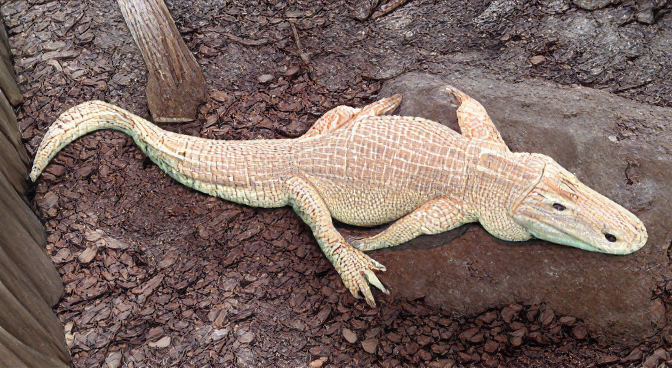

In [ ]:
#@title Hacer la ejecución...
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if textos:
    print('Using texts:', textos)
if imagenes_objetivo:
    print('Using image prompts:', imagenes_objetivo)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

cut_size = perceptor.visual.input_resolution
if is_gumbel:
    e_dim = model.quantize.embedding_dim
else:
    e_dim = model.quantize.e_dim

f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
if is_gumbel:
    n_toks = model.quantize.n_embed
else:
    n_toks = model.quantize.n_e

toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f
if is_gumbel:
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

if args.init_image:
    pil_image = Image.open(args.init_image).convert('RGB')
    pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
else:
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    if is_gumbel:
        z = one_hot @ model.quantize.embed.weight
    else:
        z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

pMs = []

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

def synth(z):
    if is_gumbel:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def add_xmp_data(nombrefichero):
    imagen = ImgTag(filename=nombrefichero)
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
    if args.prompts:
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
    else:
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', nombre_modelo, {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'input_images',str(input_images) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
    #for frases in args.prompts:
    #    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'Prompt' ,frases, {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.close()

def add_stegano_data(filename):
    data = {
        "title": " | ".join(args.prompts) if args.prompts else None,
        "notebook": "VQGAN+CLIP",
        "i": i,
        "model": nombre_modelo,
        "seed": str(seed),
        "input_images": input_images
    }
    lsb.hide(filename, json.dumps(data)).save(filename)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    add_stegano_data('progress.png')
    add_xmp_data('progress.png')
    display.display(display.Image('progress.png'))

def ascend_txt():
    global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

    result = []

    if args.init_weight:
        result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    filename = f"steps/{i:04}.png"
    imageio.imwrite(filename, np.array(img))
    add_stegano_data(filename)
    add_xmp_data(filename)
    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

i = 0
try:
    with tqdm() as pbar:
        while True:
            train(i)
            if i == max_iteraciones:
                break
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass

## Crear un zip con todas o algunas de las imágenes


In [ ]:
# Crear un zip con todas o algunas de las imágenes
imagen_inicial = 0 #@param {type:"integer"}
imagen_final = -1 #@param {type:"integer"}
paso = 50 #@param {type:"integer"}
nombre_del_archivo = "imagenes-output.zip" #@param {type:"string"}

import zipfile

if imagen_final == -1:
  imagen_final = i

zipf = zipfile.ZipFile(nombre_del_archivo, 'w', zipfile.ZIP_DEFLATED)
for i in tqdm(range(imagen_inicial, imagen_final+1, paso)):
  fname = f"{i:04}.png"
  zipf.write(f"steps/{fname}", f"{nombre_del_archivo.split('.')[0]}-{fname}")
zipf.close()
print(nombre_del_archivo, "creado. Descargando… Se abrirá el diálogo de descargas cuando finalice la descarga.")
from google.colab import files
files.download(nombre_del_archivo)

## Generar un video con los resultados

Si quieres generar un video con los frames, haz click abajo. Puedes modificar el número de FPS, el frame inicial, el último frame, etc.

In [ ]:
init_frame = 1 #Este es el frame donde el video empezará
last_frame = i #Puedes cambiar i a el número del último frame que quieres generar. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 30

total_frames = last_frame-init_frame

length = 15 #Tiempo deseado del video en segundos

frames = []
tqdm.write('Generando video...')
for i in range(init_frame,last_frame): #
    filename = f"steps/{i:04}.png"
    frames.append(Image.open(filename))

#fps = last_frame/10
fps = np.clip(total_frames/length,min_fps,max_fps)

from subprocess import Popen, PIPE
p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', 'video.mp4'], stdin=PIPE)
for im in tqdm(frames):
    im.save(p.stdin, 'PNG')
p.stdin.close()

print("El video está siendo ahora comprimido, espera...")
p.wait()
print("El video está listo")

In [ ]:
#@title Ver video en el browser
# @markdown Este proceso puede tardar un poco más. Si no quieres esperar, descárgalo ejecutando la celda siguiente en vez de usar esta celda.
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# @title Descargar video
from google.colab import files
files.download("video.mp4")